<a href="https://colab.research.google.com/github/ujjawalsingh10/Pytorch-Deep-Learning/blob/main/04_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torch import nn

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

Food101 starts 101 different classes of food and 1000 images per class (750 training and 250 testing)

Our dataset starts with 3 classes of food and only 10% of images (`75 training and 25 testing)



In [41]:
import requests
import zipfile
from pathlib import Path

# setup path to the data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

## if the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

## Download the data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
  print('Downloading the data...')
  f.write(request.content)


data/pizza_steak_sushi directory exists


In [42]:
## unzipping the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping...........')
  zip_ref.extractall(image_path)

Unzipping...........


## 2. Becoming one with the data (data preparation and exploration)

In [43]:
import os
def walkthrugh_dir(dir_path):
  """ walks thru directory and return its content """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [44]:
walkthrugh_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [45]:
## Setup train and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image
- pathlib.Path.parent.stem - to get the class name


data/pizza_steak_sushi/train/steak/165639.jpg
Image class: Steak
Image height: 382
Image width: 512


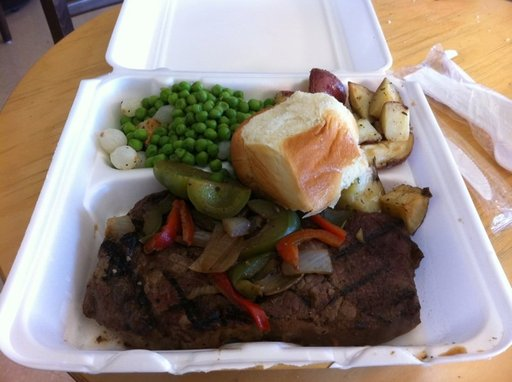

In [46]:
import random
from PIL import Image

# random.seed(42)

## get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

## get image class from path name (image class is the name of the directory)
image_class = random_image_path.parent.stem
print(f"Image class: {image_class.title()}")

## Open Image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

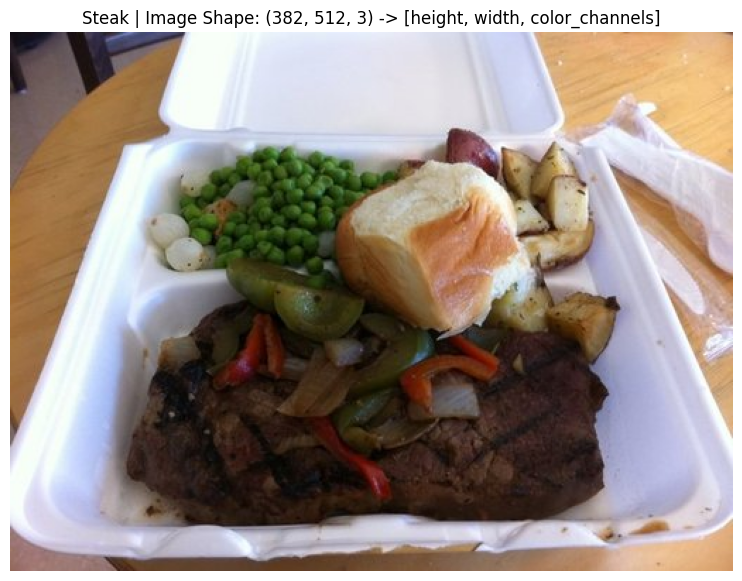

In [47]:
## visualizing the image using matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn image into array
img_as_array = np.asarray(img)

plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f"{image_class.title()} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis('off');

## 3. Transforming Data
1. Turn data into tensors
2. turn into torch.utils.data.Dataset
3. and turn that into torch.utils.data.DataLoader.... we call these dataset and dataloader

In [48]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [49]:
## write a transform for image
data_transform = transforms.Compose([
    ## resize iamges to 64x64
    transforms.Resize(size = (64, 64)),
    ## Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    ## Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [50]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  selects random images from path of iamges and loads/transforms
  then plots the original vs transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path_list, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")

      ## Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
      plt.show()


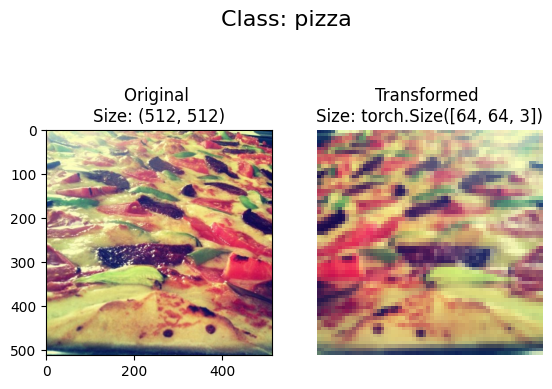

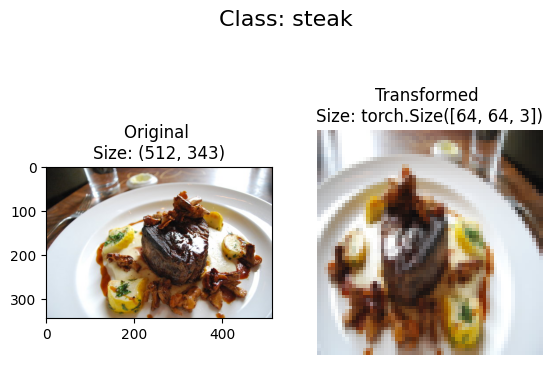

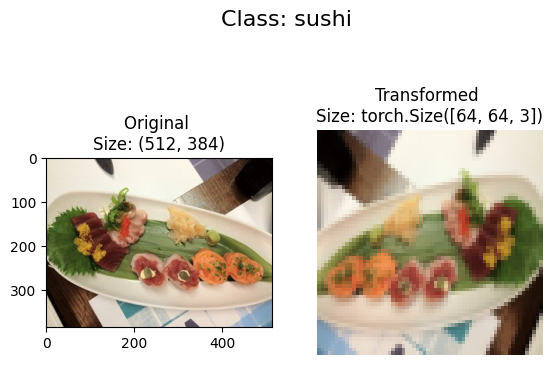

In [51]:
plot_transformed_images(image_path_list, data_transform)

## 4. Loading image data using ImageFolder

In [52]:
## use Image Folder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform,
                                  target_transform = None)

In [53]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [54]:
### get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [55]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [56]:
## check the length of the dataset
len(train_data), len(test_data)

(225, 75)

In [57]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [58]:
## Index on train_data dataset to get a single image and label
img, label = train_data[0]

(-0.5, 63.5, 63.5, -0.5)

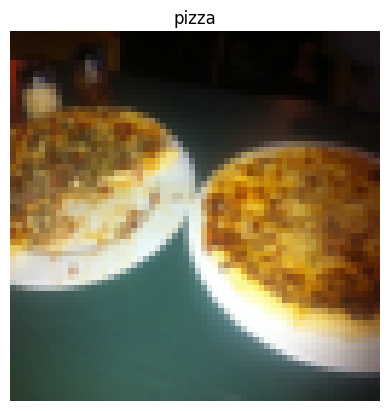

In [59]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

## 4.1 Turning loaded images into dataloaders

In [60]:
import os
os.cpu_count()

2

In [61]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size = BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle = False)

In [62]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7992e1418a50>,
 <torch.utils.data.dataloader.DataLoader at 0x7992f8ac2790>)

In [63]:
len(train_dataloader), len(test_dataloader)

(8, 3)

(-0.5, 63.5, 63.5, -0.5)

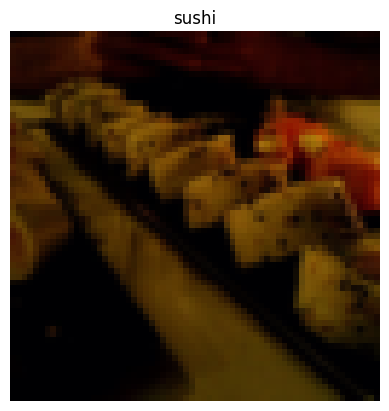

In [64]:
img, label = next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0))
plt.title(class_names[label[0]])
plt.axis('off')

## 5. Option 2: Loading Image Data with a custom Dataset

In [65]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Dict, Tuple

In [66]:
## instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [67]:
# setup path directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

## get class names from the target directory
class_names_found = sorted(entry.name for entry in os.scandir(target_directory))
print(f"Class names found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [68]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # 1. get the class names by scanning the target dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise error if class names not found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}")

  # 3. Create a dict of index labels
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [69]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

In [71]:
from torch.utils.data import Dataset

# 1.  Subclass it
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform = None):
    # 2. Create Class attribute
    # get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. create a function to load images
  def load_image(self, index: int) -> Image.Image:
    " Opens an iamge via path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self):
    return len(self.paths)

  # 6. Overwrite __getitem__() to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    " returns one of data, data and label (X,y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx # ret untransformed image and label